In [1]:
dataset_name = "W19_comb"
df_list = 'BES_Panel'
#            'BES_reduced_with_na'
#           ]#,"BESnumeric"]

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

Toggle code

In [2]:
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')

In [16]:
EverNotScot = BES_Panel[ search(BES_Panel,"^countryW").index ].replace("Scotland",np.nan).notnull().any(axis=1)

In [26]:
search(BES_Panel,"certaintyScot",mask=EverNotScot).sort_values(ascending=False).head(50)

certaintyScotUnionW3           22755
certaintyScotIndependenceW2      173
certaintyScotUnionW2             173
certaintyScotIndependenceW1      155
certaintyScotUnionW1             155
dtype: int64

In [24]:
search(BES_Panel,"scotReferendumOutside|scotIndPref|scotRefExpectation|scotRefExpectationTurnout|certaintyScotIndependence|scot|Scot",mask=EverNotScot).sort_values(ascending=False).head(50)

# euLeaveScotIndep W7-17
#    If the UK *leaves* the European Union, how much more likely is it that...
#    As a result of the UK *leaving* the European Union, how much more likely is it that...
#    Scotland would leave the UK

# happyScotIndepResult W11,W17
#    How happy or how disappointed are you that Scotland voted to remain part of the United Kingdom?

# happyScotIndepResultNoW3
#    And how happy or how disappointed would you be if the “No” side won the referendum?

# scotFairShare W1-W6
#    Would you say that each of these nations gets more or less its fair share of UK government spending?

# scotReferendumOutsideW1,W2
#    As you may know, a referendum on independence will be held in Scotland on 18th September 2014. Do
#    you think that Scotland should become an independent country or remain part of the UK?

# certaintyScotUnionW3
#    How sure are you about what would happen to Scotland if it became independent or if it stayed in the
#    United Kingdom?

# scotIndepGoodEngW1-W3
#    In general, how good or bad do you think it would be for England if Scotland became an independent country?

euLeaveScotIndepW16               34343
euLeaveScotIndepW17               31051
happyScotIndepResultW17           31051
euLeaveScotIndepW8                28894
euLeaveScotIndepW15               27789
euLeaveScotIndepW14               27738
euLeaveScotIndepW13               27499
happyScotIndepResultW11           27247
euLeaveScotIndepW11               27247
euLeaveScotIndepW10               26910
euLeaveScotIndepW7                26781
scotFairShareW4                   26188
scotFairShareW6                   24958
scotFairShareW1                   24789
scotReferendumOutsideW1           24630
scotFairShareW2                   24379
scotReferendumOutsideW2           24206
scotFairShareW3                   22757
happyScotIndepResultNoW3          22755
certaintyScotUnionW3              22755
scotIndepGoodEngW1                21138
scotIndepGoodEngW2                20598
scotIndepGoodEngW3                19511
scotIndPrefW19                     7303
responsibleCrimeScottishGovtW4     3902


In [30]:
EnglishScotIndVars = list( search(BES_Panel,"euLeaveScotIndep|happyScotIndepResultNoW3|happyScotIndepResultNoW3|scotFairShare|scotReferendumOutside|certaintyScotUnionW3|scotIndepGoodEng",mask=EverNotScot).sort_values(ascending=False).index )

In [ ]:
## do PCA/FA to get factors

## try predict on major factor?

euLeaveScotIndepW16         16380
euLeaveScotIndepW17         15629
euLeaveScotIndepW8           7368
euLeaveScotIndepW15         14090
euLeaveScotIndepW14         12622
euLeaveScotIndepW13         10496
euLeaveScotIndepW11         10883
euLeaveScotIndepW10         11715
euLeaveScotIndepW7           6268
scotFairShareW4              3307
scotFairShareW6              3469
scotFairShareW1              4698
scotReferendumOutsideW1      7680
scotFairShareW2              3440
scotReferendumOutsideW2      6760
scotFairShareW3              3588
certaintyScotUnionW3         3592
happyScotIndepResultNoW3     3592
scotIndepGoodEngW1           9913
scotIndepGoodEngW2           9289
scotIndepGoodEngW3           9321
dtype: int64

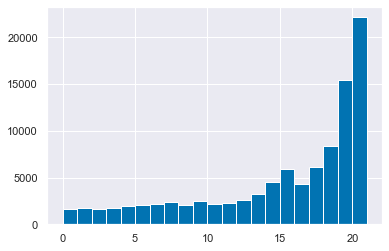

In [48]:
# pd.get_dummies( BES_Panel[EnglishScotIndVars] )
BES_Panel[EnglishScotIndVars].isnull().sum(axis=1).hist(bins=21)

mask = BES_Panel[EnglishScotIndVars].isnull().sum(axis=1) <=12
mask.sum()
BES_Panel[EnglishScotIndVars][mask].isnull().sum()

In [34]:
def dim_red(df,n_components=None,red_type="Factor Analysis",show_first_x_comps=4,display_comp=True):

    Treatment = "Census Data Decomposition"
    output_folder = "E:\\BES_analysis_data\\output\\CensusDataDecomposition\\"
    output_subfolder = output_folder + Treatment + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )

    decomp_index = df.index
    decomp_columns = df.columns
    clean_feature_set_std = StandardScaler().fit_transform(df.values)
    decomp_std = pd.DataFrame(   clean_feature_set_std,
                                 columns = decomp_columns,
                                 index   = decomp_index      )
    if n_components is None:
        n_components = decomp_std.shape[1]
    
    # n_components = 4
    # (svd_solver='full', n_components='mle',whiten=True)
    
    if red_type == "Factor Analysis":
        decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hr
    elif red_type == "PCA":
        decomp = PCA(n_components = n_components,svd_solver='full')    
    decomp_method = str(decomp).split("(")[0] 
    X_r = decomp.fit_transform(decomp_std)
    
    n_components = min(n_components,X_r.shape[1])
    BES_decomp = pd.DataFrame(   X_r,
                                 columns = range(0,n_components),
                                 index   = decomp_index)

#     save = True # False => Load
#     if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
#         decomp_method = str(decomp).split("(")[0] 
#         subdir = output_subfolder + decomp_method
#         fname = subdir+ os.sep + decomp_method
    subdir = output_subfolder + decomp_method
    if display_comp:
        (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                              decomp_columns, BES_decomp, manifest=None, 
                                                              save_folder = subdir,  
                                                              show_first_x_comps= show_first_x_comps, show_histogram = False)    
        return (BES_decomp, comp_labels, comp_dict)
    else:
        return BES_decomp

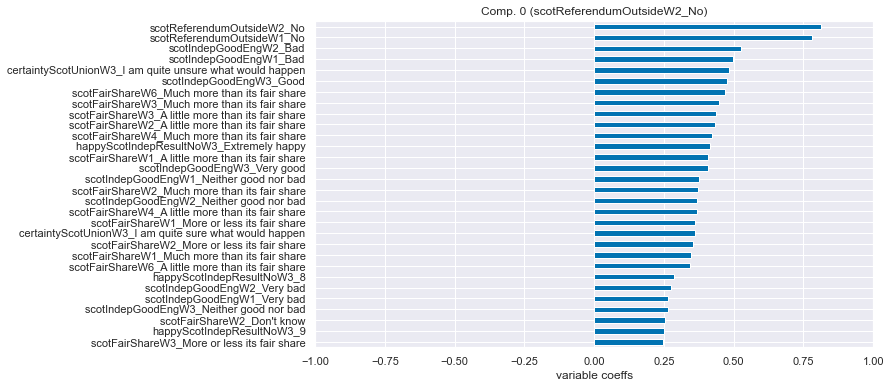

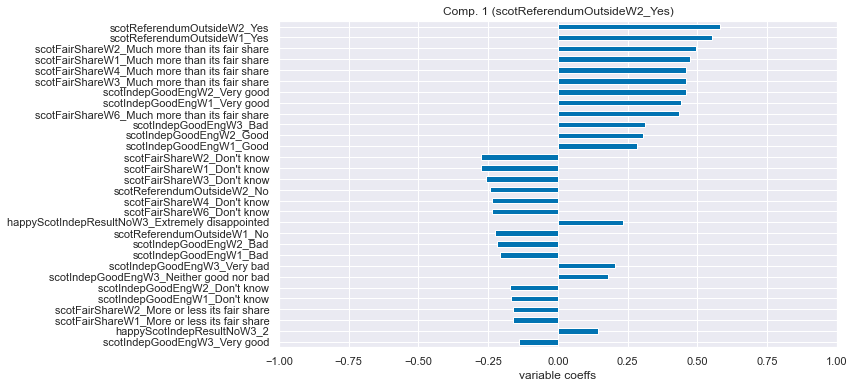

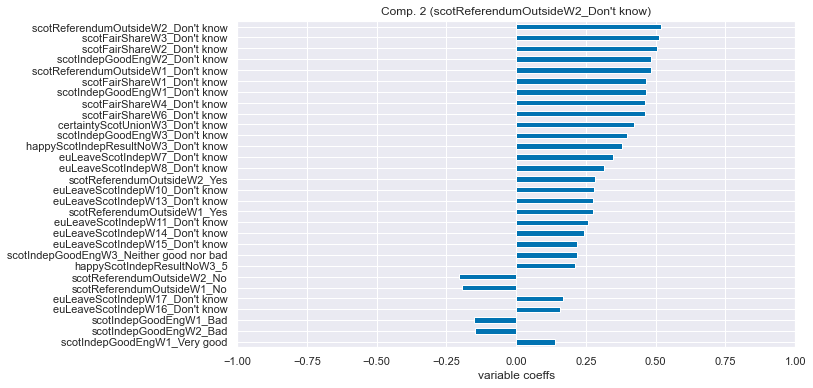

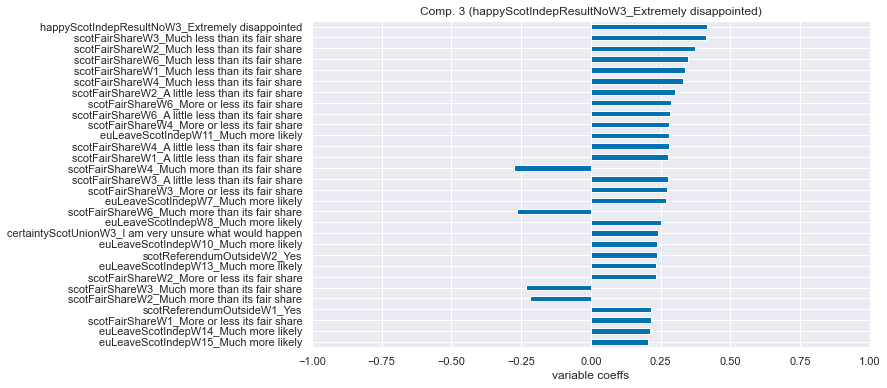

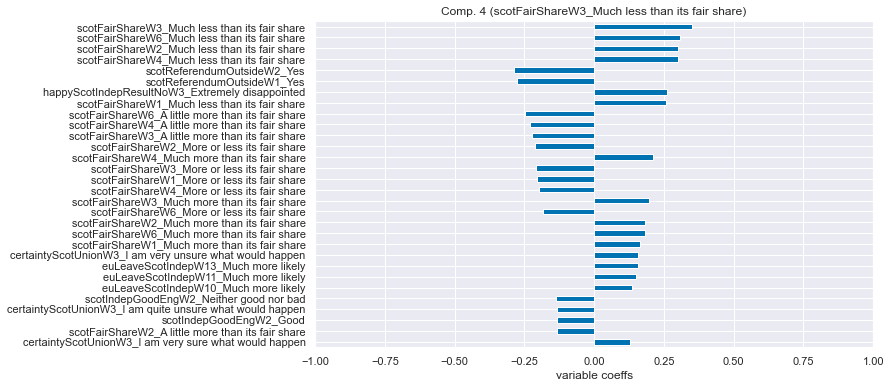

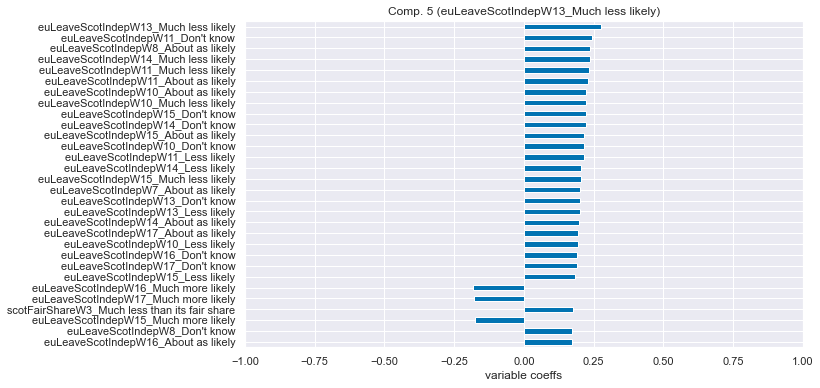

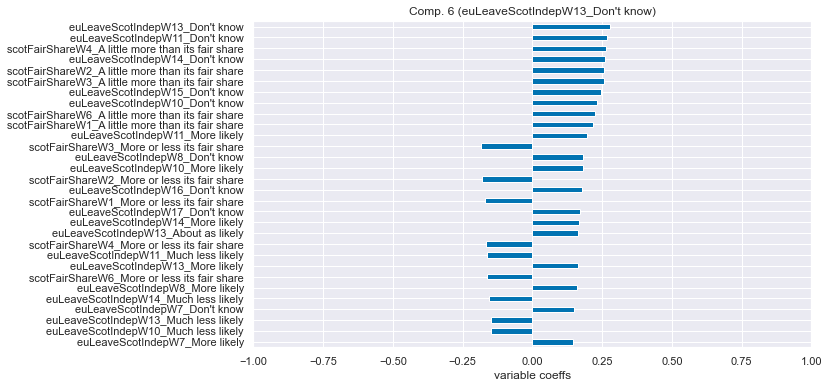

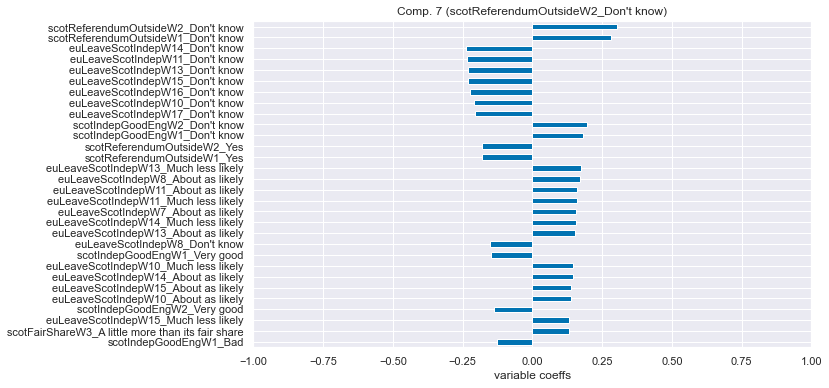

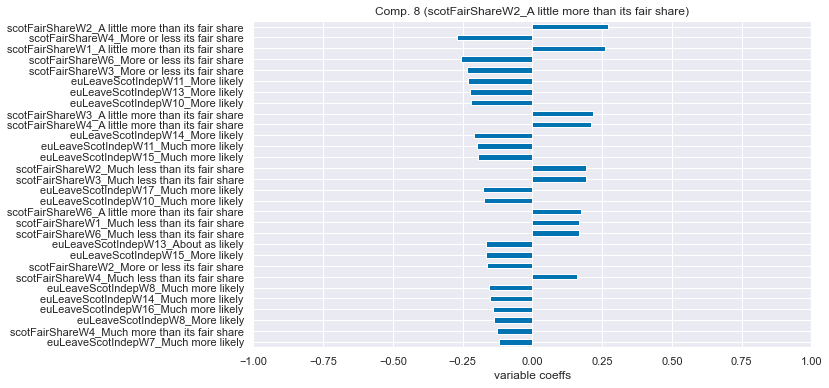

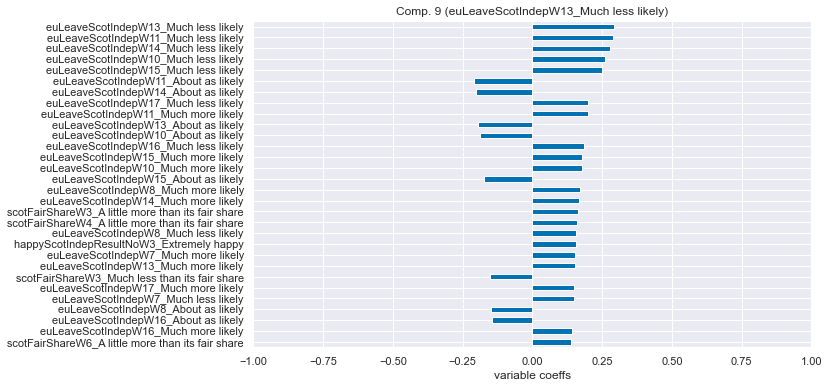

In [35]:
n_compFA = 10
n_comp = 10

(BES_decomp, comp_labels, comp_dict) = dim_red(pd.get_dummies( BES_Panel[EnglishScotIndVars] ), n_components=n_compFA,
                                               red_type="Factor Analysis",show_first_x_comps=n_comp)

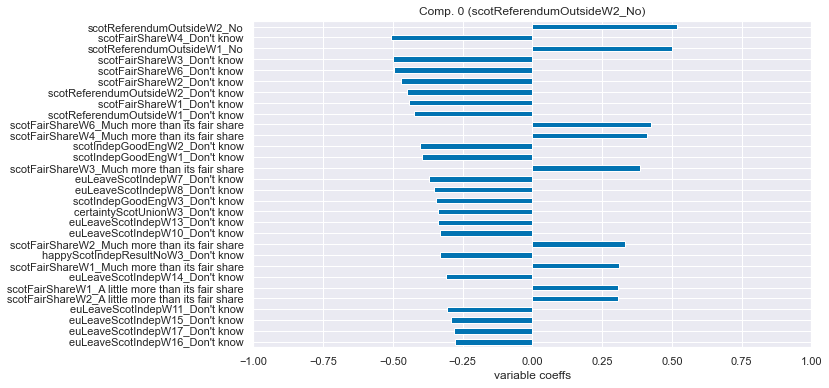

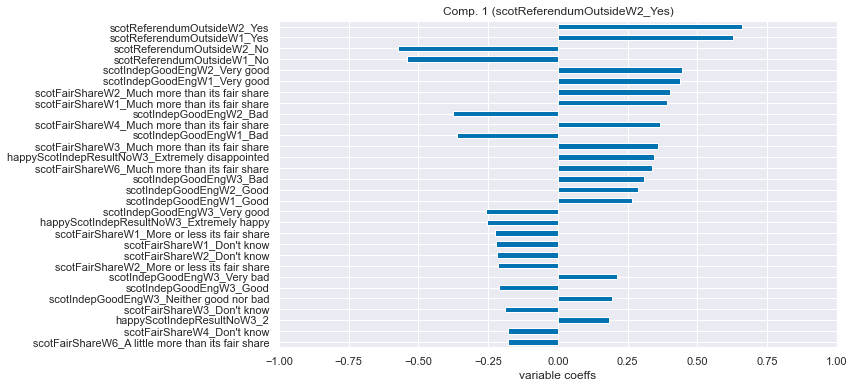

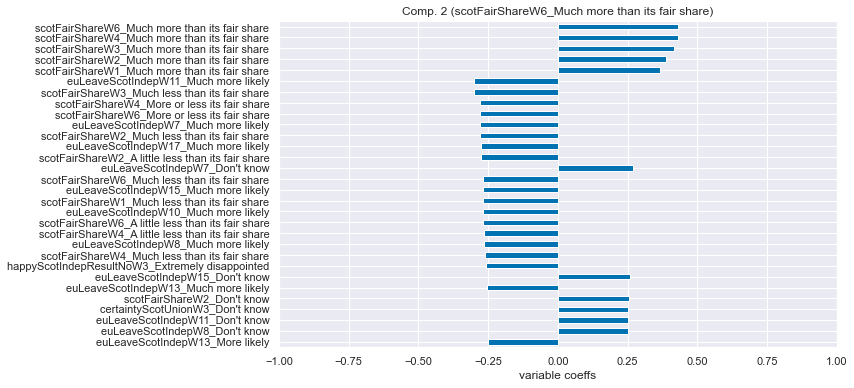

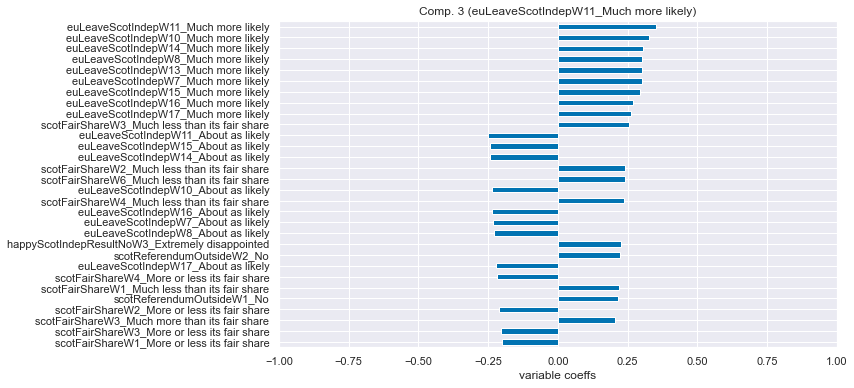

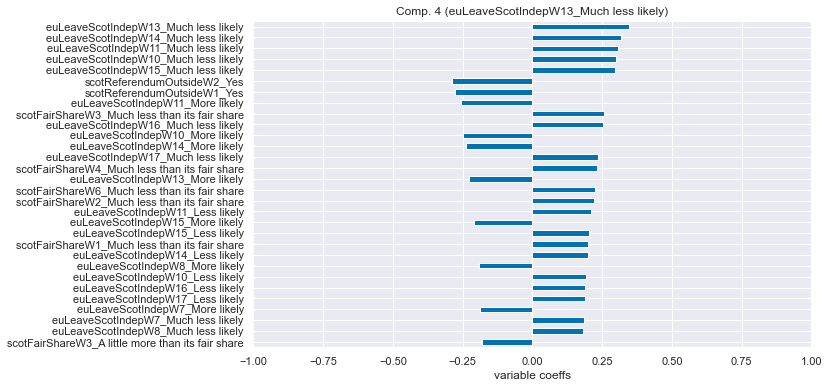

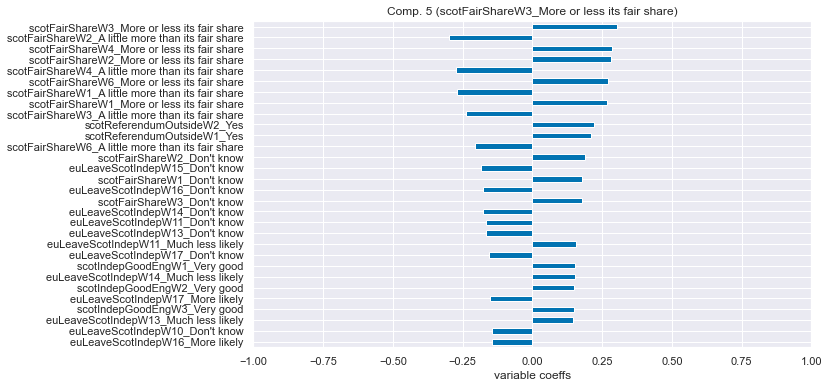

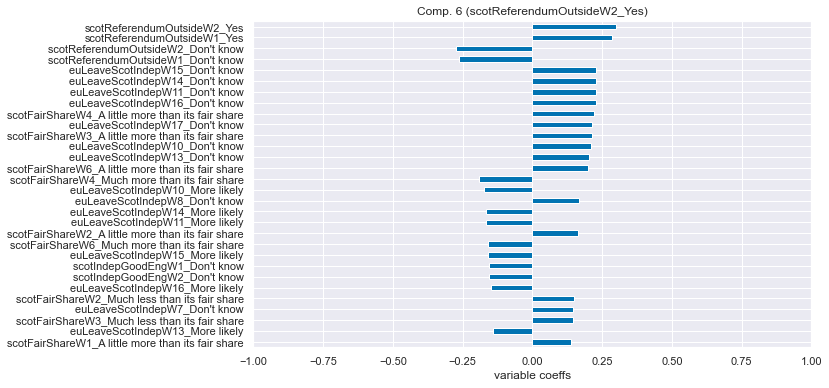

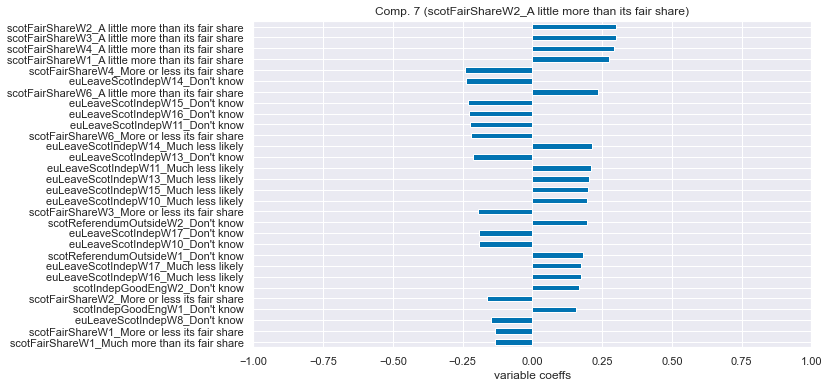

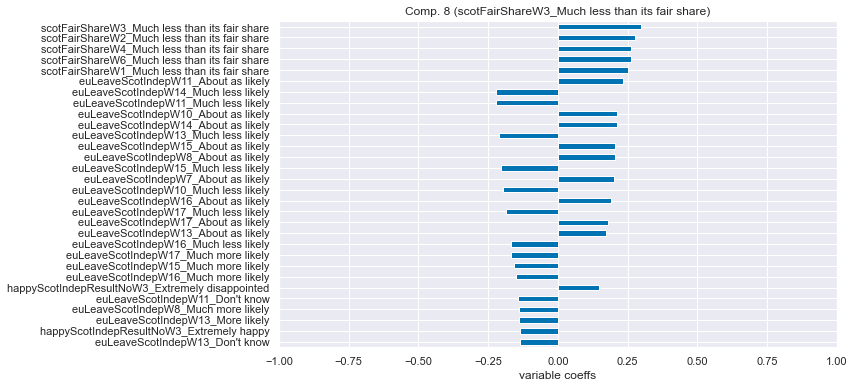

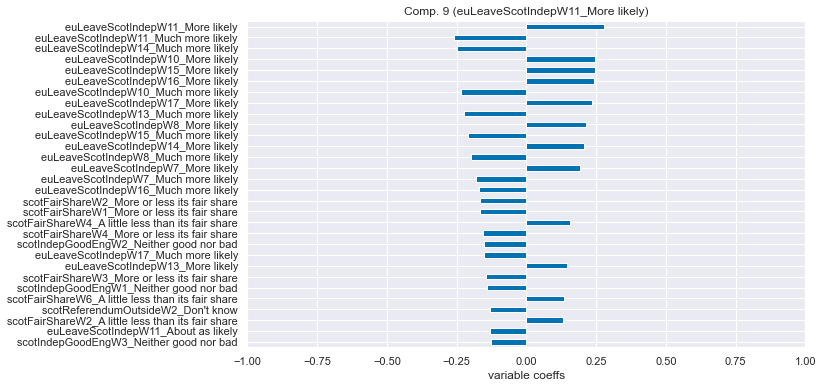

In [49]:
n_compFA = 10
n_comp = 10

(BES_decomp, comp_labels, comp_dict) = dim_red(pd.get_dummies( BES_Panel[EnglishScotIndVars][mask] ), n_components=n_compFA,
                                               red_type="Factor Analysis",show_first_x_comps=n_comp)

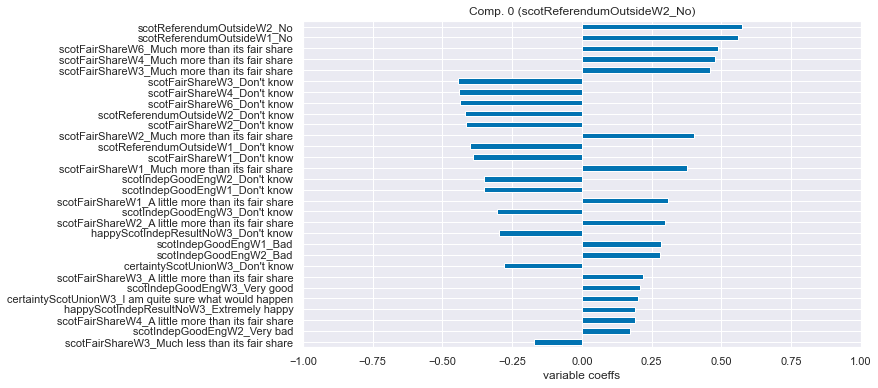

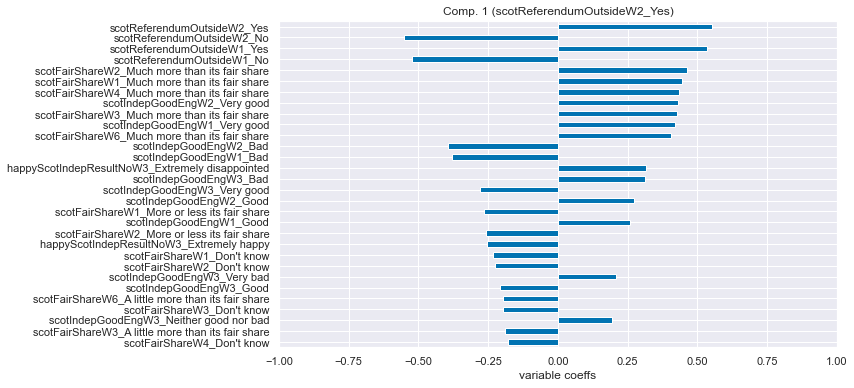

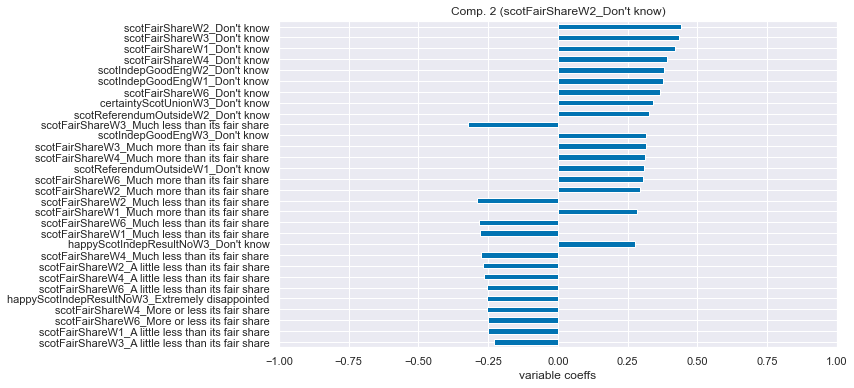

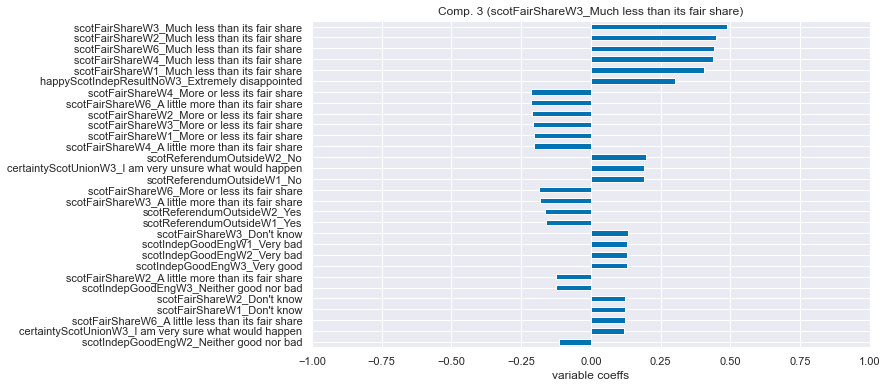

In [50]:
EnglishScotIndVars = list( search(BES_Panel,"happyScotIndepResultNoW3|happyScotIndepResultNoW3|scotFairShare|scotReferendumOutside|certaintyScotUnionW3|scotIndepGoodEng",mask=EverNotScot).sort_values(ascending=False).index )

n_compFA = 4
n_comp = 4

(BES_decomp, comp_labels, comp_dict) = dim_red(pd.get_dummies( BES_Panel[EnglishScotIndVars][mask] ), n_components=n_compFA,
                                               red_type="Factor Analysis",show_first_x_comps=n_comp)